In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import set_config

In [69]:
set_config(transform_output='pandas')

In [70]:
df = pd.read_csv("../data/preprocessed_predictive_maintenance.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   type                    10000 non-null  object 
 1   air_temperature         10000 non-null  float64
 2   process_temp            10000 non-null  float64
 3   rotational_speed_[rpm]  10000 non-null  int64  
 4   torque_[nm]             10000 non-null  float64
 5   tool_wear_[min]         10000 non-null  int64  
 6   target                  10000 non-null  int64  
 7   failure_type            10000 non-null  object 
dtypes: float64(3), int64(3), object(2)
memory usage: 625.1+ KB


In [71]:
X = df.drop(columns=['failure_type', 'target'] , axis=1)
y = df['target']

## Create Transformer 

In [72]:
num_cols = X.select_dtypes('number').columns.to_list()
cat_cols = X.select_dtypes('object').columns.to_list()

In [73]:
preprocessing = ColumnTransformer(
    [
        ('cat',OneHotEncoder(sparse_output=False , drop='if_binary'), cat_cols)
        # ('num', StandardScaler, num_cols)

    ],
    remainder='passthrough'
)
X_preprocessed = preprocessing.fit_transform(X)
X_preprocessed.head()

,cat__type_H,cat__type_L,cat__type_M,remainder__air_temperature,remainder__process_temp,remainder__rotational_speed_[rpm],remainder__torque_[nm],remainder__tool_wear_[min]
0,0.0,0.0,1.0,298.1,308.6,1551,42.8,0
1,0.0,1.0,0.0,298.2,308.7,1408,46.3,3
2,0.0,1.0,0.0,298.1,308.5,1498,49.4,5
3,0.0,1.0,0.0,298.2,308.6,1433,39.5,7
4,0.0,1.0,0.0,298.2,308.7,1408,40.0,9


In [74]:
X_preprocessed_scaled = StandardScaler().fit_transform(X_preprocessed)
X_preprocessed_scaled.head()

,cat__type_H,cat__type_L,cat__type_M,remainder__air_temperature,remainder__process_temp,remainder__rotational_speed_[rpm],remainder__torque_[nm],remainder__tool_wear_[min]
0,-0.333889,-1.224745,1.528617,-0.952389,-0.947360,0.068185,0.282200,-1.695984
1,-0.333889,0.816497,-0.654186,-0.902393,-0.879959,-0.729472,0.633308,-1.648852
2,-0.333889,0.816497,-0.654186,-0.952389,-1.014761,-0.227450,0.944290,-1.617430
3,-0.333889,0.816497,-0.654186,-0.902393,-0.947360,-0.590021,-0.048845,-1.586009
4,-0.333889,0.816497,-0.654186,-0.902393,-0.879959,-0.729472,0.001313,-1.554588


## Build Kmeans Model

In [75]:
inertias = []
sl_scores = []
n_clusters = range(2, 20)

for n_cluster in n_clusters:
    _kmeans = KMeans(n_cluster, random_state=42)
    _kmeans.fit(X_preprocessed_scaled)
    _inertia = _kmeans.inertia_

    inertias.append(_inertia)
    sl_scores.append(silhouette_score(X_preprocessed_scaled, _kmeans.labels_))

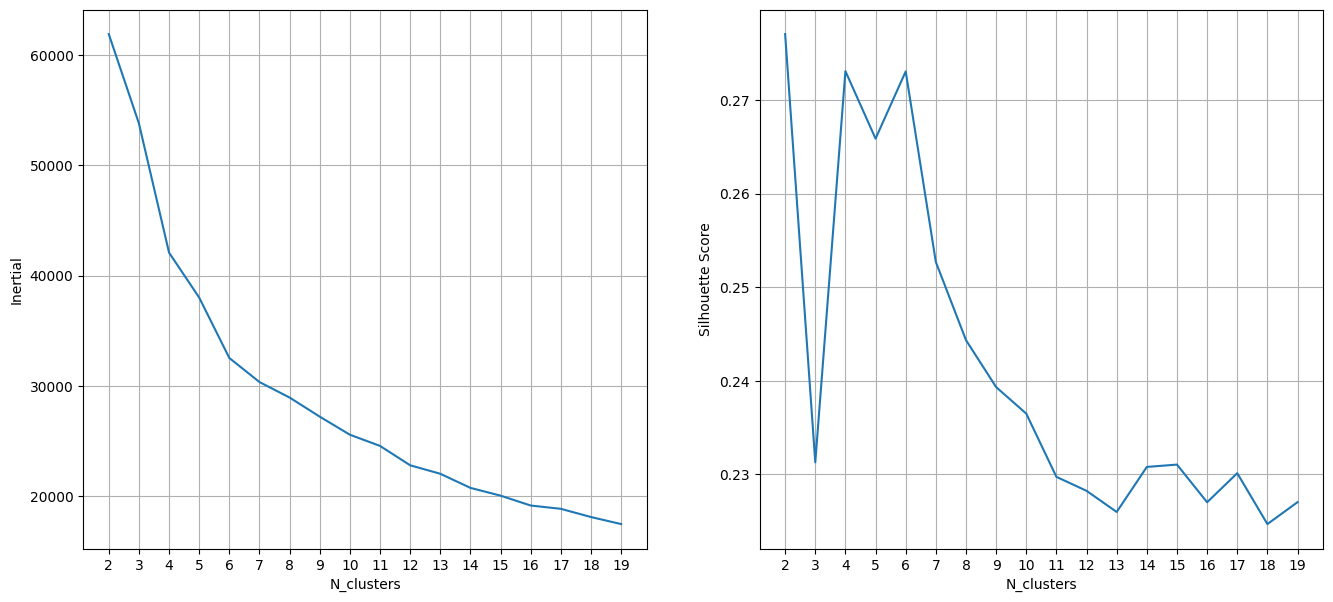

In [76]:
_, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].plot(n_clusters, inertias)
ax[1].plot(n_clusters, sl_scores)
ax[0].set_xlabel("N_clusters")
ax[0].set_ylabel("Inertial")
ax[1].set_xlabel("N_clusters")
ax[1].set_ylabel("Silhouette Score")
ax[0].set_xticks(n_clusters)
ax[1].set_xticks(n_clusters)
ax[0].grid()
ax[1].grid();

## Retain the Model With 4 clusters

In [77]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_preprocessed_scaled)

,n_clusters,4
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


In [78]:
kmeans.inertia_

42077.43328330986

### Analyze the Cluster 

In [79]:
df_cluster = df.assign(cluster_label = kmeans.labels_+1)
df_cluster.head()

,type,air_temperature,process_temp,rotational_speed_[rpm],torque_[nm],tool_wear_[min],target,failure_type,cluster_label
0,M,298.1,308.6,1551,42.8,0,0,no failure,2
1,L,298.2,308.7,1408,46.3,3,0,no failure,3
2,L,298.1,308.5,1498,49.4,5,0,no failure,3
3,L,298.2,308.6,1433,39.5,7,0,no failure,3
4,L,298.2,308.7,1408,40.0,9,0,no failure,3


In [80]:
samples_per_cluster = df_cluster["cluster_label"].value_counts()
samples_per_cluster

cluster_label
1    3027
2    2997
3    2973
4    1003
Name: count, dtype: int64

## Cluster Vs Numeric cols

cluster_label
1    301.642418
2    300.029263
3    298.359704
4    299.866999
Name: air_temperature, dtype: float64


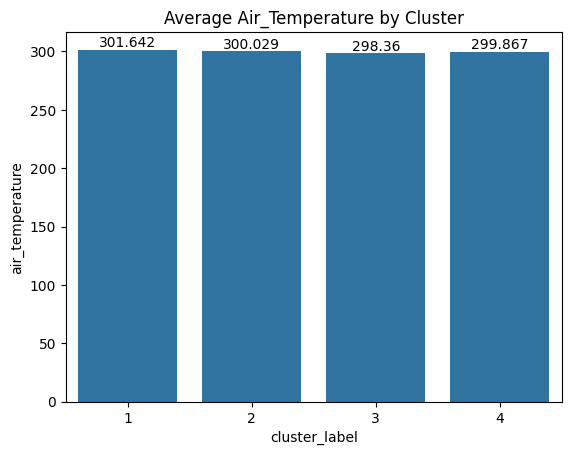

cluster_label
1    311.191080
2    310.018785
3    308.812109
4    309.925723
Name: process_temp, dtype: float64


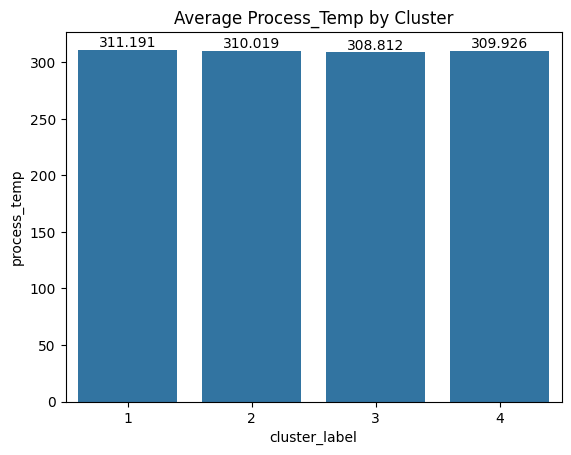

cluster_label
1    1545.019161
2    1537.598932
3    1533.818365
4    1538.147557
Name: rotational_speed_[rpm], dtype: float64


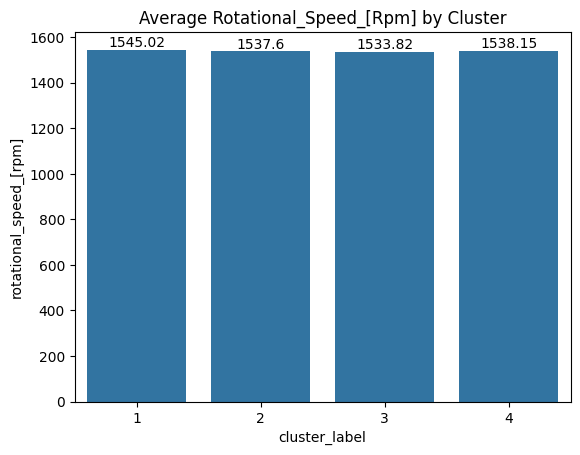

cluster_label
1    39.776412
2    40.017251
3    40.220787
4    39.838285
Name: torque_[nm], dtype: float64


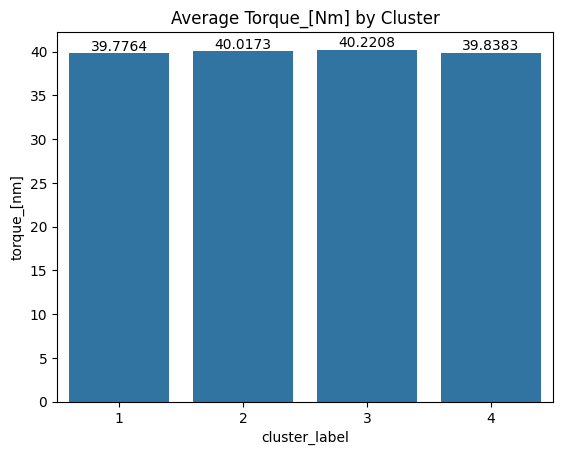

cluster_label
1    110.634291
2    107.272272
3    106.082408
4    107.419741
Name: tool_wear_[min], dtype: float64


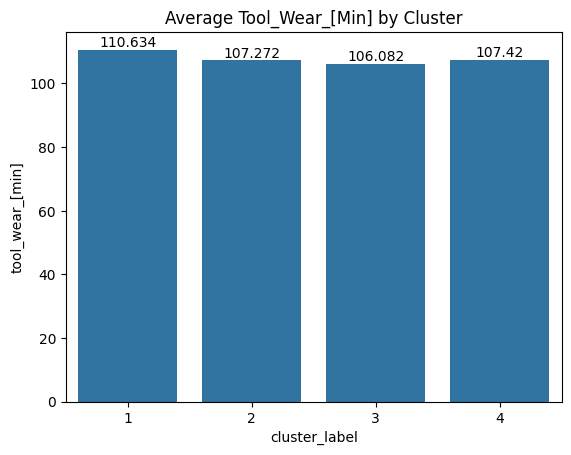

In [81]:
for col in num_cols:
    group_average = df_cluster.groupby("cluster_label")[col].mean()
    print(group_average)
    ax = sns.barplot(group_average)
    ax.bar_label(ax.containers[0])
    plt.title(f"Average {col.title()} by Cluster")
    plt.show()

### cLuster vs categorical column

In [82]:
cat_cols = df.select_dtypes('object').columns.to_list()

type             H    L    M
cluster_label               
1              0.0  1.0  0.0
2              0.0  0.0  1.0
3              0.0  1.0  0.0
4              1.0  0.0  0.0


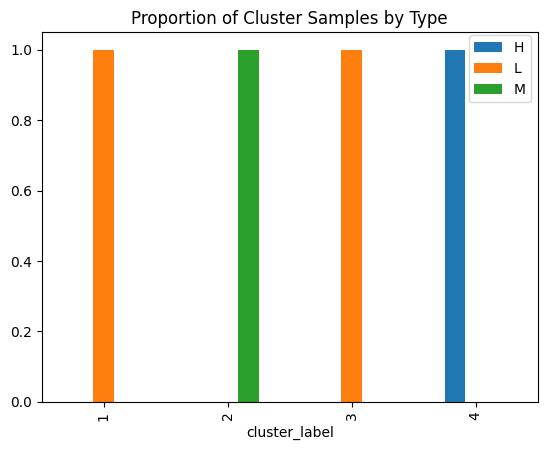

failure_type   heat dissipation failure  no failure  overstrain failure  \
cluster_label                                                             
1                              0.024447    0.946812            0.010902   
2                              0.010010    0.972973            0.001335   
3                              0.000000    0.972418            0.013454   
4                              0.007976    0.976072            0.000997   

failure_type   power failure  random failures  tool wear failure  
cluster_label                                                     
1                   0.009580         0.002973           0.005286  
2                   0.010344         0.000667           0.004671  
3                   0.010091         0.001009           0.003027  
4                   0.004985         0.003988           0.005982  


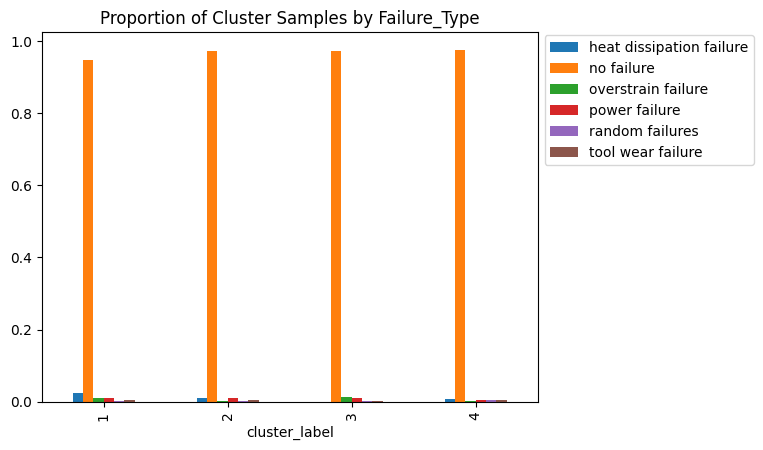

In [83]:
for col in cat_cols:
    norm_counts = pd.crosstab(df_cluster[col], df_cluster["cluster_label"], normalize="columns").T
    print(norm_counts)
    norm_counts.plot(kind="bar")
    plt.title(f"Proportion of Cluster Samples by {col.title()}")
    plt.legend(bbox_to_anchor=[1, 1.01])
    plt.show()

# Visulize the cluster

In [84]:
from sklearn.decomposition import PCA

In [85]:
pca = PCA(2)
pca.fit(X_preprocessed_scaled)

,n_components,2
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


In [86]:
pca.explained_variance_ratio_

array([0.23898095, 0.23022482])

In [87]:
df_pca = pca.transform(X_preprocessed_scaled)
df_pca.head()

,pca0,pca1
0,-1.230558,-0.902285
1,-1.507132,-0.130785
2,-1.505598,-0.316169
3,-1.140996,-0.584520
4,-1.198796,-0.454413


<Axes: xlabel='pca0', ylabel='pca1'>

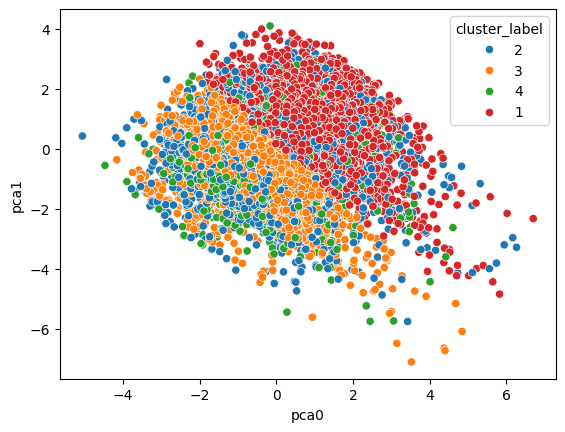

In [88]:
sns.scatterplot(x=df_pca['pca0'], y = df_pca['pca1'], hue=df_cluster['cluster_label'].astype(str))

## Check Mutual Infomation Score

In [89]:
from sklearn.metrics import mutual_info_score

In [90]:
mutual_info_score(df_cluster['target'] , df_cluster['cluster_label'])

0.0018584602040703085

## Takeaway 


* The optimal number of cluster for the kmeans is 4
* All columns Seems to Have same Average Values
* No failure Dominate Most of the cluster
* Low Type Dominate cluster 1 and cluster 2